In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats

from astropy import units as u, constants as c
from astropy.coordinates import SkyCoord

import dynesty

from tqdm.notebook import trange, tqdm

# Problem 1

In [3]:
R = 1 * u.Mpc
N = 1000 # galaxies
L = 1e10 * c.L_sun
sigma = 1000 * u.km/u.s

M_L = (sigma**2 * R / (N*c.G*L) * (c.L_sun / c.M_sun)).decompose()
M_L

<Quantity 23.25085411>

# Problem 2

In [88]:
rv = pd.read_csv("rv.dat", sep=" ", names=["radius_arcsec", "v_rad", "v_rad_err"])

def arcsec_to_radius(radius_arcsec, distance=20*u.Mpc):
    radius_rad = (radius_arcsec*u.arcsec).to(u.rad).value
    return (radius_rad*distance).to(u.kpc).value

rv["radius"] = rv.radius_arcsec.apply(arcsec_to_radius)
rv

,radius_arcsec,v_rad,v_rad_err,radius
0,76.5,15,7,7.417649
1,49.4,-4,15,4.789959
2,27.4,2,7,2.656779
3,22.2,11,3,2.152573
4,4.4,1,6,0.426636
5,15.5,-2,5,1.502922
6,71.7,-1,10,6.952228
7,21.0,-14,7,2.036217
8,37.7,-39,12,3.655495
9,49.8,-3,13,4.828744


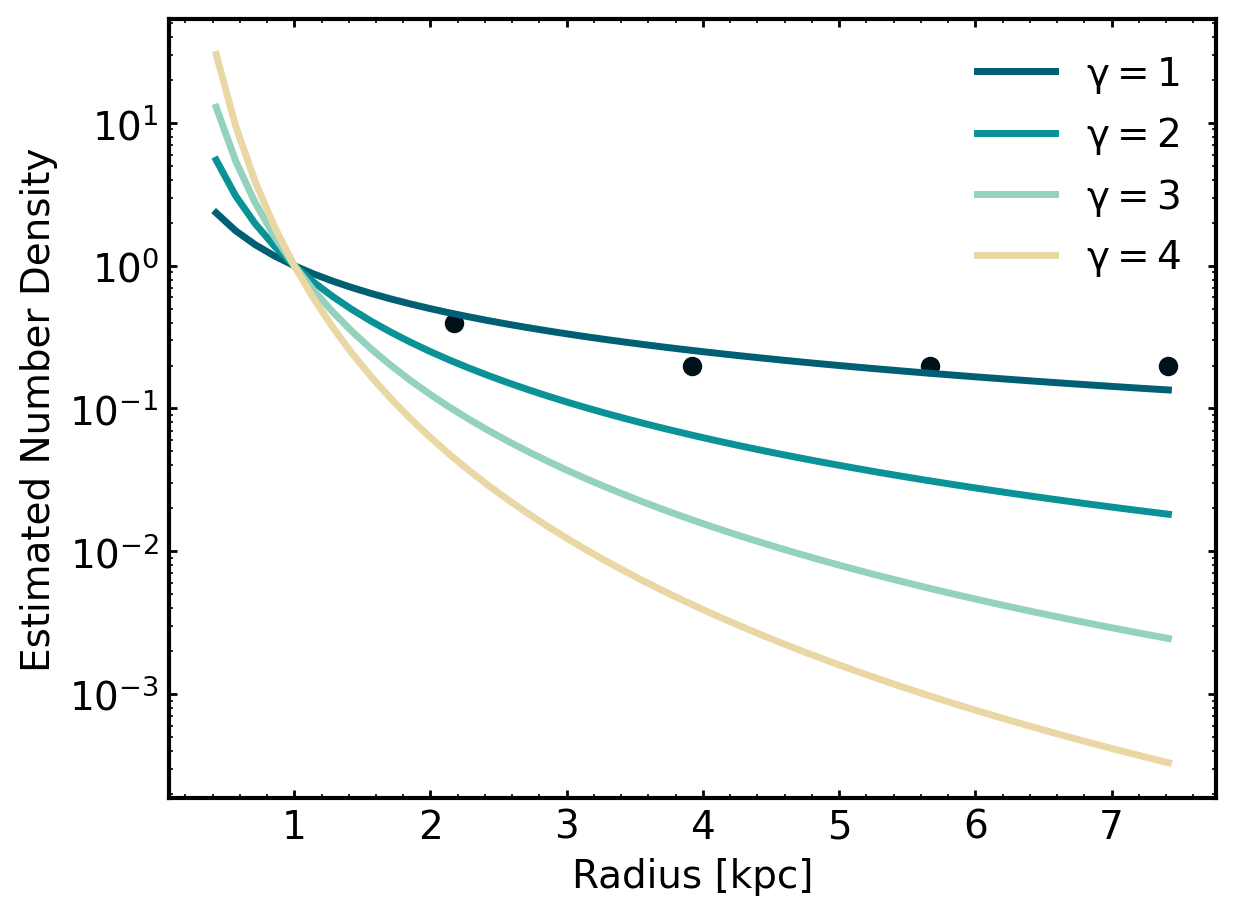

In [89]:
fig, ax = plt.subplots()

bins, edges = np.histogram(rv.radius, bins=4)
bins = bins/len(rv.radius)
ax.plot(edges[1:], bins, marker='o', linestyle="none")

def density_model(r, gamma, C=1):
    return C*r**-gamma

r = np.linspace(rv.radius.min(), rv.radius.max())
ax.plot(r, density_model(r, 1), label=r"$\gamma=1$")
ax.plot(r, density_model(r, 2), label=r"$\gamma=2$")
ax.plot(r, density_model(r, 3), label=r"$\gamma=3$")
ax.plot(r, density_model(r, 4), label=r"$\gamma=4$")

ax.set_ylabel("Estimated Number Density")
ax.set_xlabel("Radius [kpc]")

ax.set_yscale("log")
ax.legend()

In [116]:
# part (a)

def tracer_mass_estimator(Rs, rvs, gamma=1):
    assert len(Rs) == len(rvs), "Not the same number of radii and RVs!"
    N = len(Rs)
    R_min, R_max = Rs.min(), Rs.max()
        
    C = (4*gamma / np.pi) * (4-gamma/(3-gamma)) * (((1-(R_min/R_max))**(3-gamma))/((1-(R_min/R_max))**(4-gamma)))
    res = C/(c.G*N) * np.sum(Rs*rvs**2)
    
    # multiply out the rv units
    res *= u.km**2/u.s**2
    
    # multiply out the kpc for the radius units
    res *= u.kpc
    
    return res.to(u.M_sun)

tracer_mass_estimator(rv.radius, rv.v_rad)

<Quantity 8.83084683e+08 solMass>

In [123]:
# part (b)
n_bootstrap = 1e5

def do_single_bootstrap(n_bootstrap=n_bootstrap):
    Ms = []
    for _ in range(int(n_bootstrap)):

        # assume the errors are gaussian and sample from them
        v_rads = np.random.normal(rv.v_rad, rv.v_rad_err)
        M = tracer_mass_estimator(rv.radius, v_rads)
        Ms.append(M.value)
    
    return np.mean(Ms), np.std(Ms) 
    
M_mean, M_std = do_single_bootstrap()
    
    
print(fr"M = {M_mean:.2e} $\pm$ {M_std:.2e} $M_\odot$")
print("Minimum Mass = {M_mean - M_std:.2e}")

M = 1.30e+09 $\pm$ 4.95e+08 $M_\odot$
Minimum Mass = {M_mean - M_std:.2e}


17873it [00:08, 2058.81it/s, batch: 8 | bound: 6 | nc: 1 | ncall: 408532 | eff(%):  4.246 | loglstar: -78862.214 < -78857.617 < -78858.089 | logz: -78870.671 +/-  0.090 | stop:  0.908]   


Text(0.5, 0, 'Radial Velocity [km/s]')

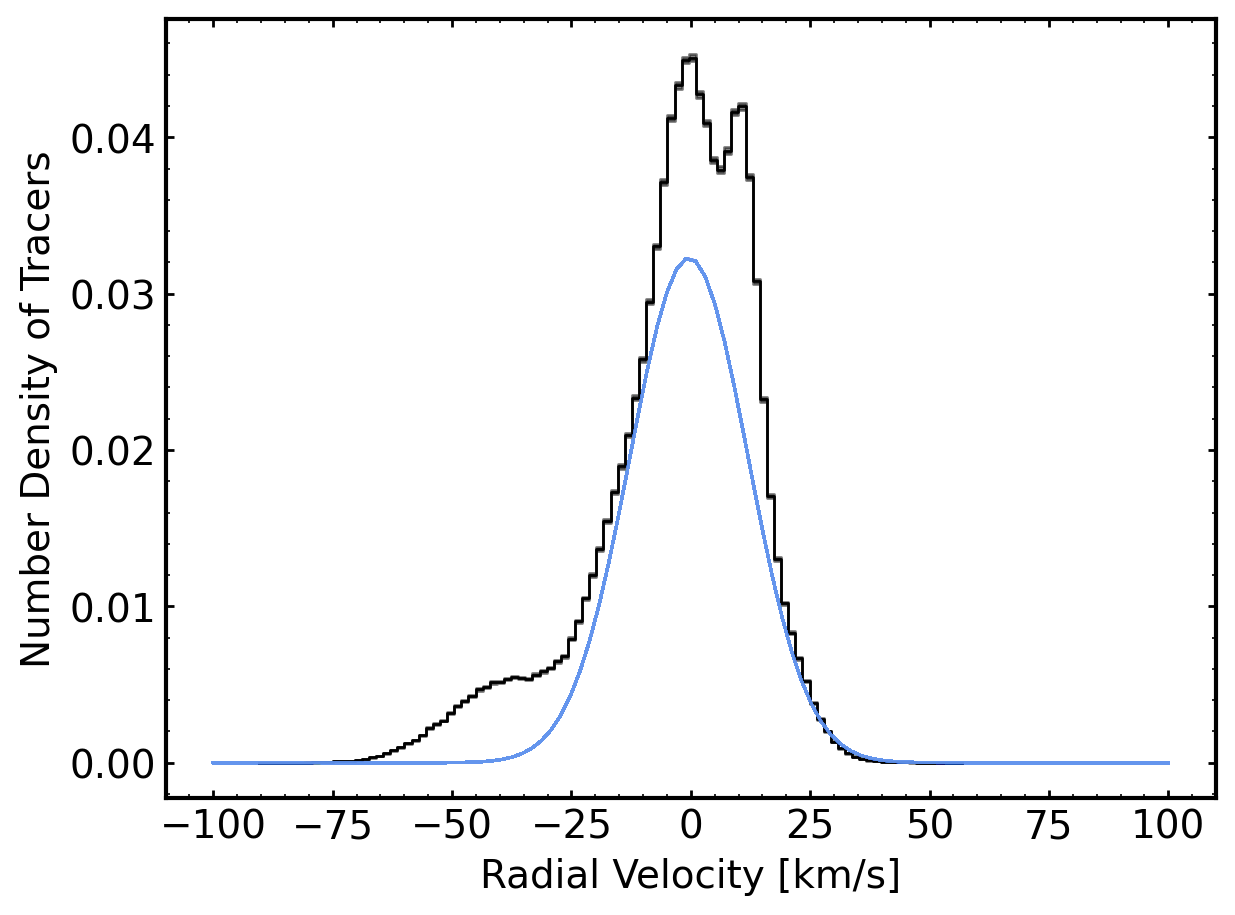

In [270]:
# part (c)

n_boostrap = 1000

fig, ax = plt.subplots()
    
def gaussian_model(x, mean, std):
    return 1/np.sqrt(2*np.pi*std**2) * np.exp(-(x-mean)**2 / (2*std**2))

def loglike(theta, x, y, yerr):
    """
    Let's just use chi2
    """
    model = gaussian_model(x, *theta)
    sigma2 = yerr**2
    
    chi2 = np.sum((y - model)**2/sigma2)
    logl = -0.5*chi2
    return logl

def prior_transform(theta):
    mean = theta[0]*40 - 20
    std = theta[1]*20
    return [mean, std]


v_rads = []
for _ in range(int(n_bootstrap)):
    # assume the errors are gaussian and sample from them
    v_rads += list(np.random.normal(rv.v_rad, rv.v_rad_err))

bins, edges = np.histogram(v_rads, bins=int(n_bootstrap//1000))

edge_mean = np.array([(edges[ii]+edges[ii+1])/2 for ii in range(len(edges)-1)])

where_nz = np.argwhere(bins).flatten()
bins = bins[where_nz]
edge_mean = edge_mean[where_nz]
loglik_kwargs = dict(
    x = edge_mean,
    y = bins/np.sum(bins),
    yerr = np.sqrt(bins)/np.sum(bins)
)

ax.step(loglik_kwargs["x"], loglik_kwargs["y"], where="mid", color='k', linewidth=1)
ax.fill_between(loglik_kwargs["x"], loglik_kwargs["y"]+loglik_kwargs["yerr"], loglik_kwargs["y"]-loglik_kwargs["yerr"], step="mid",  color='k', alpha=0.5)

sampler = dynesty.DynamicNestedSampler(
    loglike,
    prior_transform,
    ndim=2,
    nlive=500,
    logl_kwargs=loglik_kwargs,
    sample='rslice'
)

sampler.run_nested(print_progress=True)
       
nkeep = 1000
res = sampler.results.asdict()
flat_samples = res['samples']
log_prob = res['logl']
toplot = flat_samples[-nkeep:]

xplot = np.linspace(-100, 100, 100)
for val in toplot:
    ax.plot(xplot, gaussian_model(xplot, *val), color='cornflowerblue', linestyle='-', linewidth=1, alpha=0.1)
    
ax.set_ylabel("Number Density of Tracers")
ax.set_xlabel("Radial Velocity [km/s]")

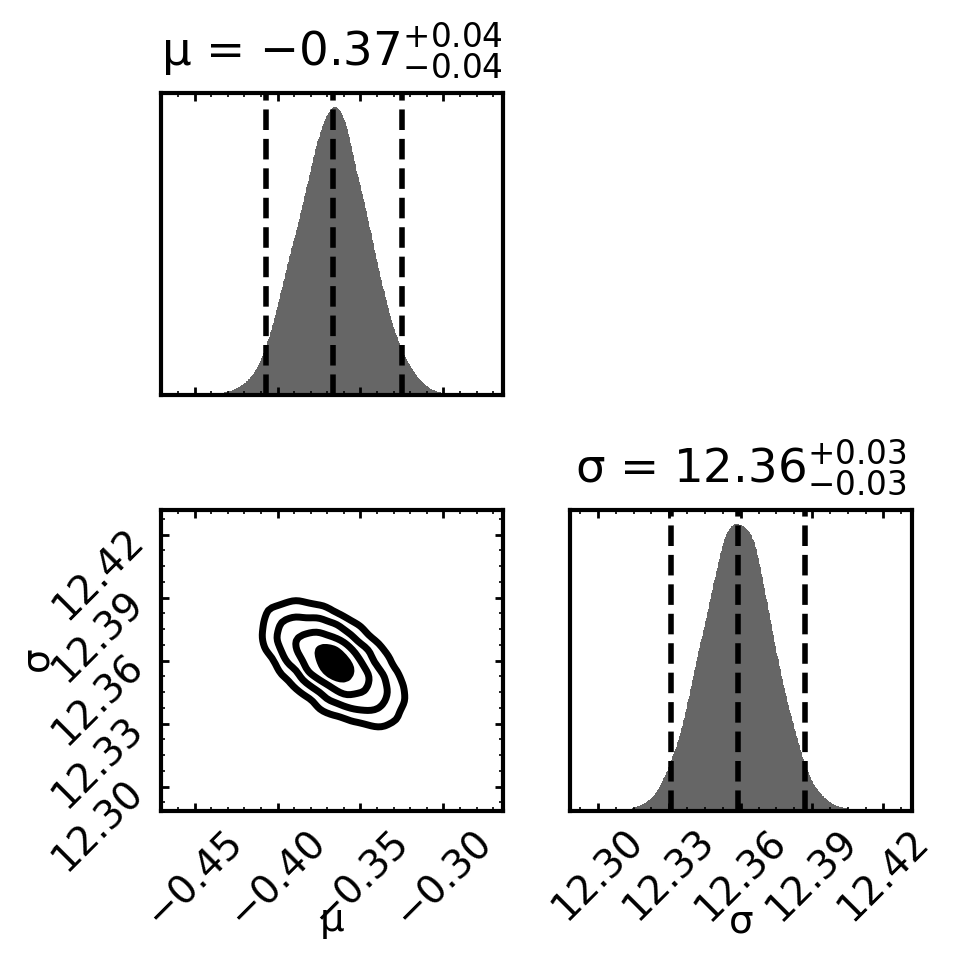

In [271]:
from dynesty import plotting as dyplot

titles = ["Radio (non-jetted)", "Radio (jetted)", "UV/Optical/IR", "X-Ray"]
labels = [r'$\mu$', r'$\sigma$']

fig, axes = dyplot.cornerplot(sampler.results, show_titles=True, 
                              title_kwargs={'y': 1.04}, labels=labels,
                              fig=plt.subplots(2, 2, figsize=(5, 5)))



# Problem 3

In [273]:
np.sqrt(c.G * 2e10 * c.M_sun / (2*u.kpc)).to(u.km/u.s)

<Quantity 207.3865297 km / s>

In [275]:
np.sqrt(c.G * 4e10 * c.M_sun / (10*u.kpc)).to(u.km/u.s)

<Quantity 131.16275798 km / s>

In [278]:
M_tot = ((235*u.km/u.s)**2 * 10*u.kpc / c.G).to(u.M_sun)
M_baryon = 4e10*u.M_sun

M_tot

<Quantity 1.28402842e+11 solMass>

In [279]:
M_tot - M_baryon

<Quantity 8.84028418e+10 solMass>

# Problem 4

In [282]:
m_B = 12.22
v_max = 324 # km/s

def tully_fisher(v_max):
    return -9.95*np.log10(v_max) + 3.15

In [284]:
# part (a)

M_B = tully_fisher(v_max)
M_B

-21.82992285155579

In [287]:
# part (b)

def d(m, M):
    return u.pc * 10**((m-M)/5 + 1)

d(m_B, M_B).to(u.Mpc)

<Quantity 64.56312905 Mpc>

In [291]:
# part (c)
M_Bsun = 5.48

L = 10**(0.4 * (M_Bsun - M_B)) * u.L_sun
L

<Quantity 8.3940034e+10 solLum>

In [ ]:
# part (d)



In [292]:
# part (e)

# Problem 5

Text(0.5, 0, '$r ~[a_p]$')

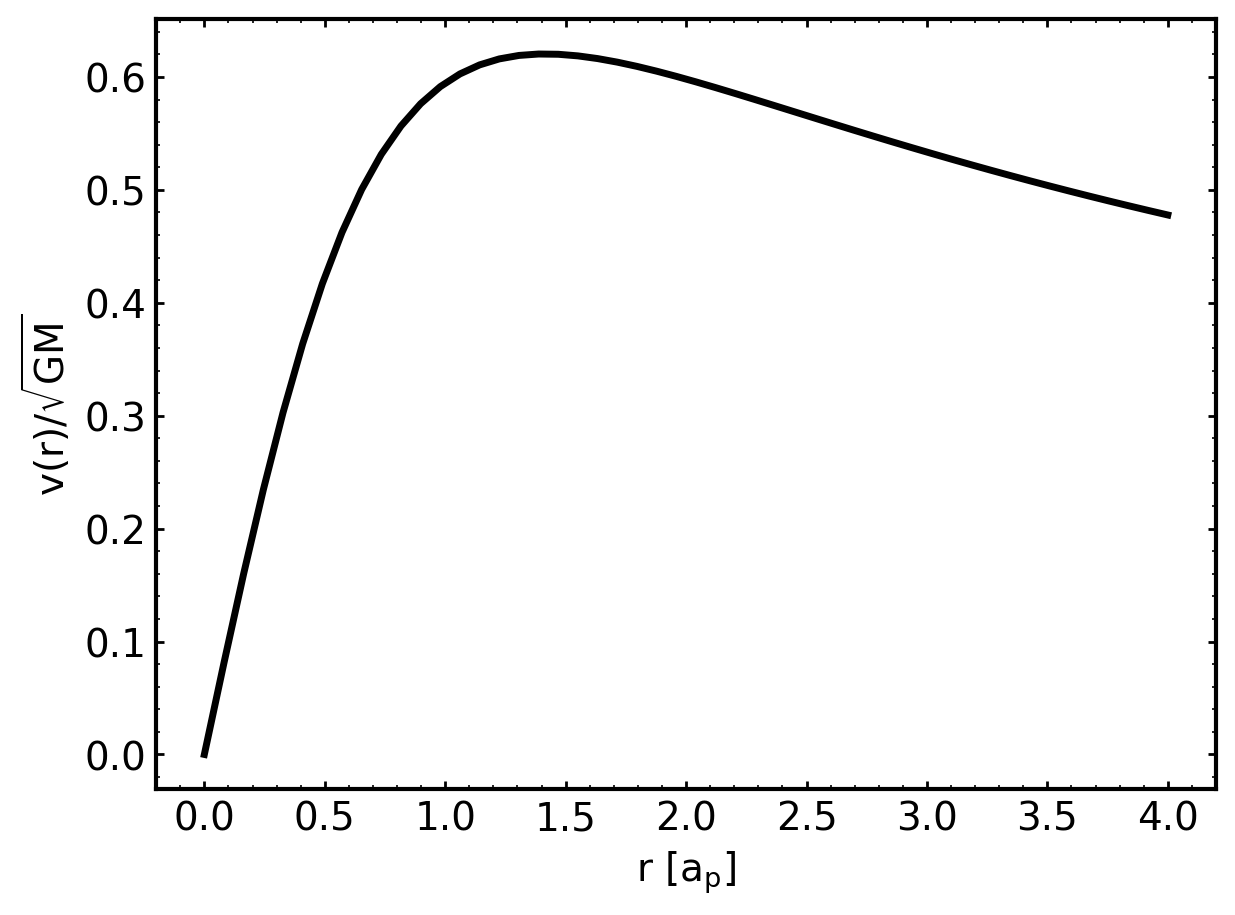

In [300]:
def V(r):
    return r*(r**2 + 1)**-0.75

r = np.linspace(0, 4)
fig, ax = plt.subplots()
ax.plot(r, V(r), color='k')

ax.set_ylabel(r"$v(r) / \sqrt{GM}$")
ax.set_xlabel(r"$r ~[a_p]$")